In [19]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [2]:
# Flags
LOG_DIR = ".graph"
TRAIN_DIR = 'resTrain/'

In [3]:
def augment(force=False):
    if not(force):
        # check if transformed image directory exits
        # read and randomly sample from directory
        pass
    else:
        # overwrite image directory 
        # perform all image transformation
        pass

In [4]:
label = pd.read_csv("labels.csv", delimiter=',', index_col=0) # 120 labels
labelOneHot = pd.get_dummies(label.breed) # 120 labels

global curr_batch  # flag to track current batch being fed in each epoch
curr_batch = 0     # first initialization, re-initialize with caution

'''
input batch-size, default = 100
uses global variable curr_batch to remember current batch location
returns tuple (flag for next batch, list of files, list of labels, 4-d array->(batch, h, w, c))
'''
def next_batch(batch_size=25, random=False):
    next_batch = True
    if random:
        label_list = labelOneHot.sample(n=batch_size, replace=False)
        batch_list = label_list.index
    else:
        global curr_batch
        start = curr_batch*batch_size
        end   = (curr_batch+1)*batch_size
        # print("feeding Batch : " + str(curr_batch))
        # Check is it's last batch
        if ((curr_batch+1)*batch_size>len(label)):
            end = len(file_list)-1
            next_batch = False
        batch_list = label.index[start:end]
        label_list = labelOneHot[start:end]
    
    batch = []
    for img in batch_list:
        pic = cv2.imread(TRAIN_DIR+img+".jpg", cv2.IMREAD_UNCHANGED)
        batch.append(pic)
    batch = np.stack(batch, axis=0)
    if not(random):
        curr_batch = curr_batch + 1
    
    return next_batch, batch_list, label_list, batch

In [5]:
def conv_layer(input, size_in, size_out, name="conv"):
  with tf.name_scope(name):
    w = tf.Variable(tf.truncated_normal([3, 5, 5, size_in, size_out], stddev=0.1), name="W")
    b = tf.Variable(tf.constant(0.1, shape=[size_out]), name="B")
    conv = tf.nn.conv3d(input, w, strides=[1, 1, 1, 1, 1], padding="SAME")
    act = tf.nn.relu(conv + b)
    tf.summary.histogram("weights", w)
    tf.summary.histogram("biases", b)
    tf.summary.histogram("activations", act)
    return tf.nn.max_pool(act, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")


def fc_layer(input, size_in, size_out, name="fc"):
  with tf.name_scope(name):
    w = tf.Variable(tf.truncated_normal([size_in, size_out], stddev=0.1), name="W")
    b = tf.Variable(tf.constant(0.1, shape=[size_out]), name="B")
    act = tf.matmul(input, w) + b
    tf.summary.histogram("weights", w)
    tf.summary.histogram("biases", b)
    tf.summary.histogram("activations", act)
    return act


In [ ]:
with tf.namescome("model"):
    x_image = tf.placeholder(tf.float32, shape=(None, 224, 224, 3), name="Input_Image")
    y       = tf.placeholder(tf.float32, shape=(None, 120), name="True_Label")
    
    act1 = conv_layer(x_image, (BATCH_SIZE, 224, 224, 3), (BATCH_SIZE, ))
    

In [9]:
_, _, _,img0 = next_batch()

In [588]:
''' Image Transformation Definitions '''
'''
randomly crop image
set kee_dim true to keep input and out put dimensions same
cropped height and width fraction
'''
def random_crop(input, h_frac=0.6, w_frac=0.6, keep_dim=True):
    height, width, _ = input.shape
    h, w = int(h_frac*height), int(w_frac*width)
    y, x = np.random.randint(0, height-h), np.random.randint(0, width-w)
    if keep_dim:
        return cv2.resize(input[x:x+w, y:y+h, :], (height, width), interpolation=cv2.INTER_CUBIC)
    else:
        return input[x:x+w, y:y+h, :]

'''
Performs gaussian or median blur of random strength
upper limit of blur strength can be passes as parameter
'''
def random_blur(input, max_strength=0.3):
    h, w, _ = input.shape
    rand = np.random.randint(0, max_strength*h)
    if rand%2==0:
        max_strength = max_strength/2
        a, b = np.random.randint(1, int(max_strength*h)), np.random.randint(1, int(max_strength*w))
        a, b = 2*a+1, 2*b+1 
        return cv2.GaussianBlur(input,(a, b),0)
    else:
        rand = 2*int(rand/4)+1
        print("here: "+str(rand))
        return cv2.medianBlur(input,rand)

'''
randomly rotate the image about center with scale factor of 1.1
'''
def random_rotate(input):
    rows, cols, _ = input.shape
    theta = np.random.randint(0, 360)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),theta,1.1)
    return cv2.warpAffine(input,M,(cols,rows))

def random_noise(input, strength=None):
    a, b, c = input.shape
    if strength==None:
        strength = np.random.randint(0, 50)
    noise = np.random.randn(a, b, c)
    out = input+strength*noise
    a = np.max(out); b = min(0, np.min(out))
    return np.uint8(254/(a-b)*(out-b))
     


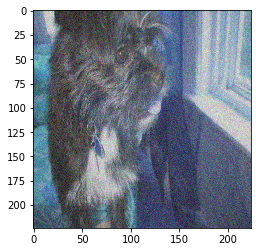

In [596]:
plt.imshow(random_noise(img0[5,:,:,:]))

In [551]:
np.random.randint(0, 80)

23